In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import h5py
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *
from UniversalUnconsciousness.power_analysis import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [5]:
cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15
cfg.params.window = 15

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]


In [ ]:
from sklearn.model_selection import cross_val_score
top_percent = 0.1

lever_window = 120
analysis_window = 15

data_class, agent = ('anesthesiaLvrOdd', 'dexmedetomidine')
session_lists = agent_data[('anesthesiaLvrOdd', 'dexmedetomidine')]['session_lists']

single_session_tracking_data = {}

pct_correct_thresh_options = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def plot_single_session_tracking(session, pct_correct_thresh, time_vals, stab_means, stab_sems, high_perf_times, high_perf_mask):
    plt.plot(time_vals, stab_means, color=curve_colors[agent])
    plt.fill_between(time_vals, stab_means - stab_sems, stab_means + stab_sems, alpha=0.2, color=curve_colors[agent])
    plt.fill_between(high_perf_times, plt.ylim()[0], plt.ylim()[1], 
                        where=high_perf_mask,
                        color='green', alpha=0.1)
    plt.xlabel('Time Relative to Anesthesia Start (min)')
    plt.ylabel('Mean Instability ($s^{-1}$)')
    plt.savefig(os.path.join(img_save_dir, f'{session}_tracking_pct_correct_{pct_correct_thresh}.pdf'), dpi=300, bbox_inches='tight', transparent=True)
    plt.show()


iterator = tqdm(total=(len(session_lists['SPOCK']['high']) + len(session_lists['PEDRI']['high']))*len(pct_correct_thresh_options))

for pct_correct_thresh in pct_correct_thresh_options:
    single_session_tracking_data[pct_correct_thresh] = {}
    for monkey in ['SPOCK', 'PEDRI']:
        single_session_tracking_data[pct_correct_thresh][monkey] = {}
        for session in session_lists[monkey]['high']:
            cfg.params.data_class = data_class
            delase_results = agent_data[(data_class, agent)]['delase_results']

            area = 'all'

            if 'propofol' in cfg.params.data_class:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class, f'{session}.mat'), 'r')
            else:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f'{session}.mat'), 'r')

            freq_band_to_plot = 'None'

            if 'propofol' not in cfg.params.data_class:
                infusion_start = session_file['sessionInfo']['infusionStart'][0, -1]
            else:
                infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
            stab_means = delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean())
            stab_sems = delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].std()/np.sqrt(len(x[:int(top_percent*len(x))])))
            time_vals = (delase_results[session][area].window_start - infusion_start)/60
            time_vals = time_vals

            if 'propofol' not in cfg.params.data_class:
                pct_correct, pct_correct_windows = get_pct_correct(cfg, session_file, lever_window=120, stride=15)
                high_perf_times = (pct_correct_windows - infusion_start)/60
                high_perf_mask = (pct_correct > pct_correct_thresh) | (pct_correct_windows <= infusion_start)

            # skip first 4 elements to center the window on the relevant pct_correct window bc lever_window=120
            skip_elems = int(lever_window/analysis_window)
            stab_means = stab_means[skip_elems:]
            perf_start_times = np.array([int(np.round(t)) for t in pct_correct_windows + 60])
            stab_start_times = np.array([int(np.round(t)) for t in (time_vals[skip_elems:]*60 + infusion_start).to_numpy()])
            time_bool1 = np.array([t in stab_start_times for t in perf_start_times])
            time_bool2 = np.array([t in perf_start_times for t in stab_start_times])
            stab_means = stab_means[time_bool2]
            high_perf_mask = high_perf_mask[time_bool1]
            awake_stab_means[monkey][session] = stab_means[high_perf_mask].mean()
            unconscious_stab_means[monkey][session] = stab_means[~high_perf_mask].mean()
            single_session_tracking_data[pct_correct_thresh][monkey][session] = {
                'time_vals': time_vals,
                'stab_means': stab_means,
                'stab_sems': stab_sems,
                'high_perf_times': high_perf_times,
                'high_perf_mask': high_perf_mask,
                'awake_stab_means': stab_means[high_perf_mask].mean(),
                'unconscious_stab_means': stab_means[~high_perf_mask].mean()
            }

            # num_elems = min(len(stab_means), len(high_perf_mask))
            # stab_means = stab_means[:num_elems]
            # high_perf_mask = high_perf_mask[:num_elems]
            # awake_stab_means[monkey][session] = stab_means[high_perf_mask].mean()
            # unconscious_stab_means[monkey][session] = stab_means[~high_perf_mask].mean()

            X = stab_means.values.reshape(-1, 1)
            y = high_perf_mask.astype(int)

            # Use 5-fold cross-validation for robust AUROC computation
            log_reg = LogisticRegression()
            cv_scores = cross_val_score(log_reg, X, y, cv=5, scoring='roc_auc')
            # stab_aurocs[monkey][session] = np.mean(cv_scores)
            single_session_tracking_data[pct_correct_thresh][monkey][session]['stab_aurocs'] = np.mean(cv_scores)

            linear_reg = LinearRegression()
            stab_spectrum = delase_results[session]['all'].stability_params.apply(lambda x: x[:int(0.1*len(x))])[4:]
            min_num = min([len(x) for x in stab_spectrum.to_numpy()])
            stab_spectrum = np.vstack(stab_spectrum.apply(lambda x: x[:min_num]).to_numpy())
            num_elems = min(len(stab_spectrum), len(pct_correct))
            stab_spectrum = stab_spectrum[:num_elems]
            pct_correct = pct_correct[:num_elems]

            mse_scores = cross_val_score(linear_reg, stab_spectrum, pct_correct, cv=5, scoring='neg_mean_squared_error')
            r2_scores = cross_val_score(linear_reg, stab_spectrum, pct_correct, cv=5, scoring='r2')
            single_session_tracking_data[pct_correct_thresh][monkey][session]['stab_mse_vals'] = -np.mean(mse_scores)
            single_session_tracking_data[pct_correct_thresh][monkey][session]['stab_r2_vals'] = np.mean(r2_scores)

            area = 'all'

            save_dir = "/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/power_analysis"
            agent_save_dir = os.path.join(save_dir, data_class, agent, area)
            if not os.path.exists(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl')):
                print(f"Session {session} does not exist, skipping")
            else:
                ret_dict = pd.read_pickle(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl'))

            single_session_tracking_data[pct_correct_thresh][monkey][session]['band_aurocs'] = {}
            single_session_tracking_data[pct_correct_thresh][monkey][session]['band_mse_vals'] = {}
            single_session_tracking_data[pct_correct_thresh][monkey][session]['band_r2_vals'] = {}
            for band in ['delta', 'theta', 'alpha']:
                freq_power = ret_dict['freq_powers'][band].reshape(-1, 1)
                freq_power = freq_power[skip_elems:] 
                num_elems = min(len(freq_power), len(high_perf_mask))
                freq_power = freq_power[:num_elems]
                y = high_perf_mask[:num_elems].astype(int)
                
                # Use 5-fold cross-validation for robust AUROC computation
                log_reg = LogisticRegression()
                cv_scores = cross_val_score(log_reg, freq_power, y, cv=5, scoring='roc_auc')
                single_session_tracking_data[pct_correct_thresh][monkey][session]['band_aurocs'][band] = np.mean(cv_scores)

                pct_correct = pct_correct[:num_elems]
                y = pct_correct.reshape(-1, 1)
                linear_reg = LinearRegression()

                mse_scores = cross_val_score(linear_reg, freq_power, pct_correct, cv=5, scoring='neg_mean_squared_error')
                r2_scores = cross_val_score(linear_reg, freq_power, pct_correct, cv=5, scoring='r2')

                single_session_tracking_data[pct_correct_thresh][monkey][session]['band_mse_vals'][band] = -np.mean(mse_scores)
                single_session_tracking_data[pct_correct_thresh][monkey][session]['band_r2_vals'][band] = np.mean(r2_scores)
            
            # ffts = pd.read_pickle(os.path.join(save_dir, data_class, agent, area, f"{session}__fft_analysis.pkl"))['ffts'][4:]
            # dt = 0.001
            # window = int((delase_results[session][area].window_end.iloc[0] - delase_results[session][area].window_start.iloc[0])/dt)
            # freqs = np.fft.rfftfreq(window, d=dt)
            # linear_reg = LinearRegression()
            # num_elems = min(ffts.shape[0], len(pct_correct))
            # ffts = ffts[:num_elems]
            # fft_power = np.abs(ffts.mean(axis=-1)[:, freqs <= 12])**2
            # pct_correct = pct_correct[:num_elems]

            # mse_scores = cross_val_score(linear_reg, fft_power, pct_correct, cv=5, scoring='neg_mean_squared_error')
            # r2_scores = cross_val_score(linear_reg, fft_power, pct_correct, cv=5, scoring='r2')

            # spectral_mse_vals[monkey][session] = -np.mean(mse_scores)
            # spectral_r2_vals[monkey][session] = np.mean(r2_scores)

            iterator.update(1)
iterator.close()


  0%|          | 0/144 [00:00<?, ?it/s]

In [83]:
# for i,monkey in enumerate(['SPOCK', 'PEDRI']):
#     awake_stab_means_all = list(awake_stab_means[monkey].values())
#     unconscious_stab_means_all = list(unconscious_stab_means[monkey].values())
#     # Data for plotting
#     labels = ['Responsive', 'Unresponsive']
#     stab_means_all = [awake_stab_means_all, unconscious_stab_means_all]

#     fig, ax = plt.subplots(figsize=(3, 2))
#     bp = ax.boxplot(stab_means_all, labels=labels,
#                     medianprops=dict(color='black'),
#                     patch_artist=True, showfliers=False)  # This enables filling of the boxes

#     # Set colors for each box
#     colors = ['green', 'purple']
#     for patch, color in zip(bp['boxes'], colors):
#         patch.set_facecolor(color)
#     # Add labels and title
#     ax.set_ylabel('Mean Instability ($s^{-1}$)')
#     ax.set_title(f'NHP{i + 3}')

#     plt.savefig(os.path.join(img_save_dir, f'NHP{i + 3}_single-session-tracking-means.pdf'), dpi=300, bbox_inches='tight', transparent=True)

#     # Show plot
#     plt.show()



monkey: SPOCK, p: 0.00390625


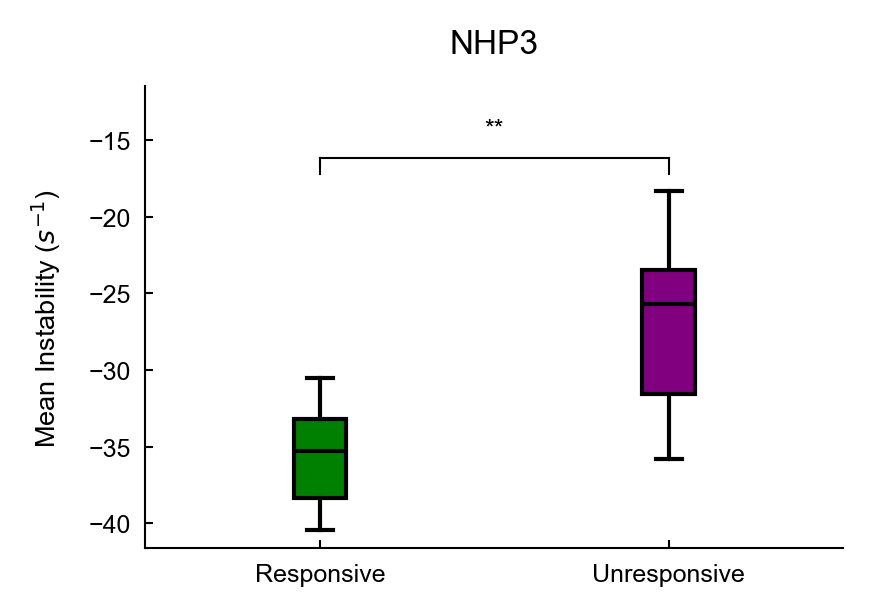

monkey: PEDRI, p: 0.00390625


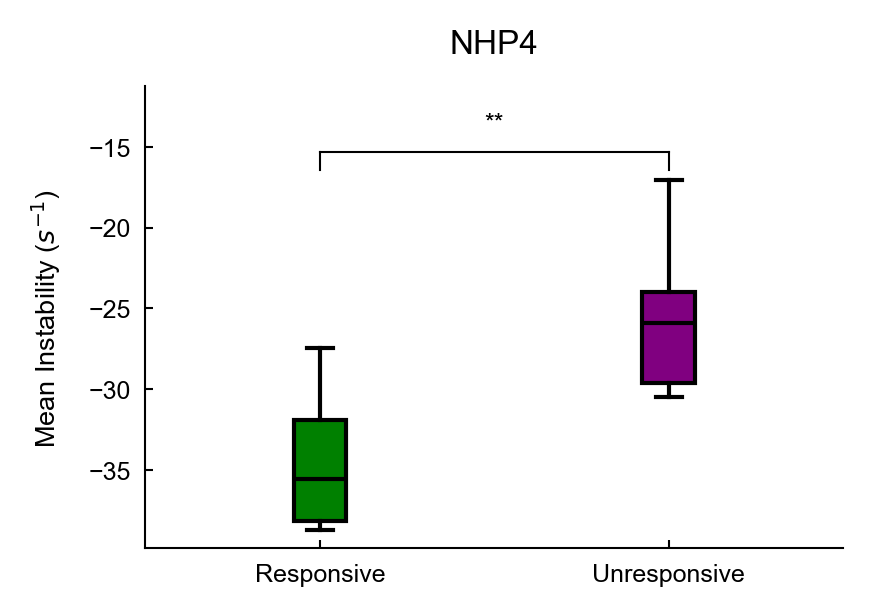

In [51]:
# Add these imports at the top of your notebook if not already present
from scipy.stats import wilcoxon
import numpy as np

pct_correct_thresh = 0.1

# Then modify your plotting code to include the statistical testing
for i,monkey in enumerate(['SPOCK', 'PEDRI']):
    awake_stab_means_all = [single_session_tracking_data[pct_correct_thresh][monkey][session]['awake_stab_means'] for session in single_session_tracking_data[pct_correct_thresh][monkey]]
    unconscious_stab_means_all = [single_session_tracking_data[pct_correct_thresh][monkey][session]['unconscious_stab_means'] for session in single_session_tracking_data[pct_correct_thresh][monkey]]
    # Data for plotting
    labels = ['Responsive', 'Unresponsive']
    stab_means_all = [awake_stab_means_all, unconscious_stab_means_all]

    # Perform Mann-Whitney U test
    stat, p = wilcoxon(awake_stab_means_all, unconscious_stab_means_all, alternative='less')
    print(f"monkey: {monkey}, p: {p}")
    
    fig, ax = plt.subplots(figsize=(3, 2))
    bp = ax.boxplot(stab_means_all, tick_labels=labels,
                    medianprops=dict(color='black'),
                    patch_artist=True, showfliers=False)  # This enables filling of the boxes

    # Set colors for each box
    colors = ['green', 'purple']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Add significance bar
    y_max = max([max(data) for data in stab_means_all])
    y_min = min([min(data) for data in stab_means_all])
    y_range = y_max - y_min
    
    # Calculate significance stars
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = 'ns'
    
    # Add significance bar with stars
    x1, x2 = 1, 2  # positions of the two groups
    y_bar_max = y_max
    # Adjust offset based on monkey (NHP 3 or NHP 4)
    offset = 0.08 * y_range if monkey == 'PEDRI' else 0.1 * y_range  # Smaller offset for NHP 4
    tick_length = 0.05 * y_range
    
    y_bar = y_bar_max + offset
    ax.plot([x1, x2], [y_bar, y_bar], 'k-')
    ax.plot([x1, x1], [y_bar, y_bar - tick_length], 'k-')
    ax.plot([x2, x2], [y_bar, y_bar - tick_length], 'k-')
    text_obj = ax.text((x1 + x2) / 2, y_bar + tick_length, stars, ha='center', va='bottom')
    
    # Ensure the figure is drawn so that the text's bounding box is available
    plt.draw()
    
    # Get the renderer from the figure's canvas
    renderer = text_obj.figure.canvas.get_renderer()
    
    # Obtain the bounding box in display (pixel) coordinates
    bbox = text_obj.get_window_extent(renderer=renderer)
    
    # Convert the top of the bounding box (y1) into data coordinates
    top_x, top_y = ax.transData.inverted().transform((bbox.x1, bbox.y1))
    # if we've exceeded the ylim, set the ylim to the y_bar_min including the offset and text
    if top_y > ax.get_ylim()[1]:
        ax.set_ylim(ax.get_ylim()[0], top_y + offset)
    
    # Add labels and title
    ax.set_ylabel('Mean Instability ($s^{-1}$)')
    ax.set_title(f'NHP{i + 3}')

    plt.savefig(os.path.join(img_save_dir, f'NHP{i + 3}_single-session-tracking-means_percent_correct_{pct_correct_thresh}.pdf'), dpi=300, bbox_inches='tight', transparent=True)

    # Show plot
    plt.show()

In [89]:
accuracy_data = {}
mse_data = {}
r2_data = {}
for monkey in ['SPOCK', 'PEDRI']:
    accuracy_data[monkey] = {}
    mse_data[monkey] = {}
    r2_data[monkey] = {}
    for pct_correct_thresh in pct_correct_thresh_options:
            stab_aurocs_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['stab_aurocs'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])
            delta_aurocs_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['band_aurocs']['delta'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])
            theta_aurocs_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['band_aurocs']['theta'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])
            alpha_aurocs_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['band_aurocs']['alpha'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])

            delta_p_value = wilcoxon(stab_aurocs_all, delta_aurocs_all, alternative='greater').pvalue
            theta_p_value = wilcoxon(stab_aurocs_all, theta_aurocs_all, alternative='greater').pvalue
            alpha_p_value = wilcoxon(stab_aurocs_all, alpha_aurocs_all, alternative='greater').pvalue

            accuracy_data[monkey][pct_correct_thresh] = {
                'stab_aurocs_all': stab_aurocs_all,
                'delta_aurocs_all': delta_aurocs_all,
                'theta_aurocs_all': theta_aurocs_all,
                'alpha_aurocs_all': alpha_aurocs_all,
                'delta_p_value': delta_p_value,
                'theta_p_value': theta_p_value,
                'alpha_p_value': alpha_p_value
            }

            stab_mse_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['stab_mse_vals'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])
            delta_mse_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['band_mse_vals']['delta'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])
            theta_mse_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['band_mse_vals']['theta'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])
            alpha_mse_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['band_mse_vals']['alpha'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])
            
            delta_p_value = wilcoxon(stab_mse_all, delta_mse_all, alternative='less').pvalue
            theta_p_value = wilcoxon(stab_mse_all, theta_mse_all, alternative='less').pvalue
            alpha_p_value = wilcoxon(stab_mse_all, alpha_mse_all, alternative='less').pvalue

            mse_data[monkey][pct_correct_thresh] = {
                'stab_mse_all': stab_mse_all,
                'delta_mse_all': delta_mse_all,
                'theta_mse_all': theta_mse_all,
                'alpha_mse_all': alpha_mse_all,
                'delta_p_value': delta_p_value,
                'theta_p_value': theta_p_value,
                'alpha_p_value': alpha_p_value
            }

            stab_r2_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['stab_r2_vals'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])
            delta_r2_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['band_r2_vals']['delta'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])
            theta_r2_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['band_r2_vals']['theta'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])
            alpha_r2_all = list([single_session_tracking_data[pct_correct_thresh][monkey][session]['band_r2_vals']['alpha'] for session in single_session_tracking_data[pct_correct_thresh][monkey]])

            delta_p_value = wilcoxon(stab_r2_all, delta_r2_all, alternative='less').pvalue
            theta_p_value = wilcoxon(stab_r2_all, theta_r2_all, alternative='less').pvalue
            alpha_p_value = wilcoxon(stab_r2_all, alpha_r2_all, alternative='less').pvalue

            r2_data[monkey][pct_correct_thresh] = {
                'stab_r2_all': stab_r2_all,
                'delta_r2_all': delta_r2_all,
                'theta_r2_all': theta_r2_all,
                'alpha_r2_all': alpha_r2_all,
                'delta_p_value': delta_p_value,
                'theta_p_value': theta_p_value,
                'alpha_p_value': alpha_p_value
            }

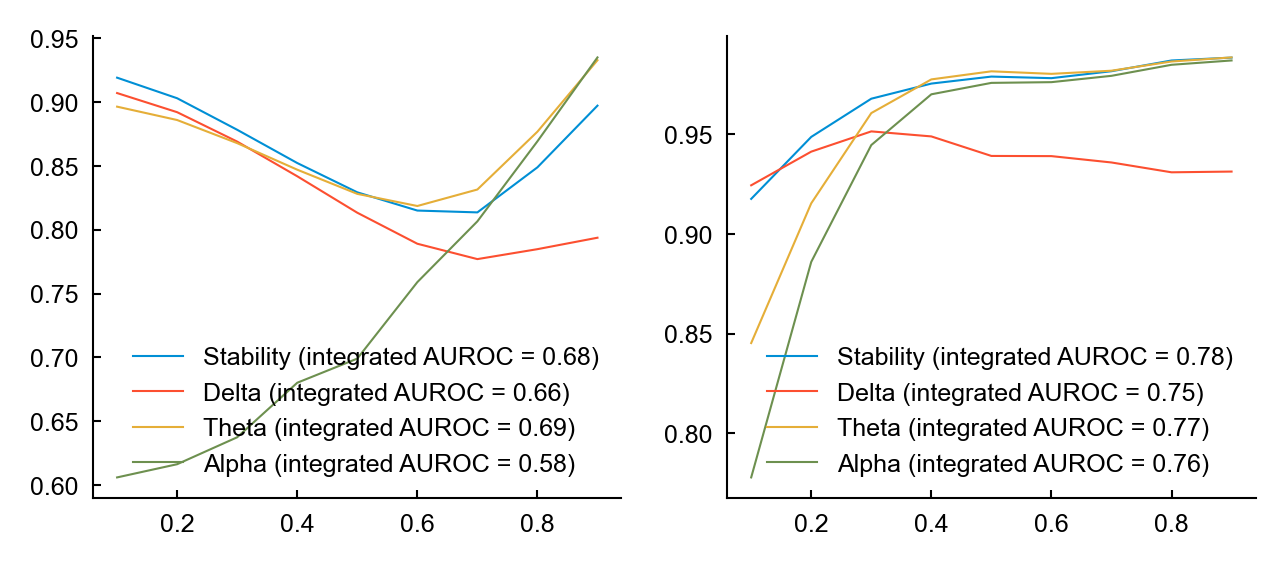

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2))

for i, monkey in enumerate(['SPOCK', 'PEDRI']):
    stab_pct_thresh_curve = np.array([np.mean(accuracy_data[monkey][pct_correct_thresh]['stab_aurocs_all']) for pct_correct_thresh in pct_correct_thresh_options])
    delta_pct_thresh_curve = np.array([np.mean(accuracy_data[monkey][pct_correct_thresh]['delta_aurocs_all']) for pct_correct_thresh in pct_correct_thresh_options])
    theta_pct_thresh_curve = np.array([np.mean(accuracy_data[monkey][pct_correct_thresh]['theta_aurocs_all']) for pct_correct_thresh in pct_correct_thresh_options])
    alpha_pct_thresh_curve = np.array([np.mean(accuracy_data[monkey][pct_correct_thresh]['alpha_aurocs_all']) for pct_correct_thresh in pct_correct_thresh_options])
    stab_int = np.trapezoid(stab_pct_thresh_curve, pct_correct_thresh_options)
    delta_int = np.trapezoid(delta_pct_thresh_curve, pct_correct_thresh_options)
    theta_int = np.trapezoid(theta_pct_thresh_curve, pct_correct_thresh_options)
    alpha_int = np.trapezoid(alpha_pct_thresh_curve, pct_correct_thresh_options)
    axs[i].plot(pct_correct_thresh_options, stab_pct_thresh_curve, label='Stability (integrated AUROC = {:.2f})'.format(stab_int))
    axs[i].plot(pct_correct_thresh_options, delta_pct_thresh_curve, label='Delta (integrated AUROC = {:.2f})'.format(delta_int))
    axs[i].plot(pct_correct_thresh_options, theta_pct_thresh_curve, label='Theta (integrated AUROC = {:.2f})'.format(theta_int))
    axs[i].plot(pct_correct_thresh_options, alpha_pct_thresh_curve, label='Alpha (integrated AUROC = {:.2f})'.format(alpha_int))
    axs[i].legend()
plt.show()

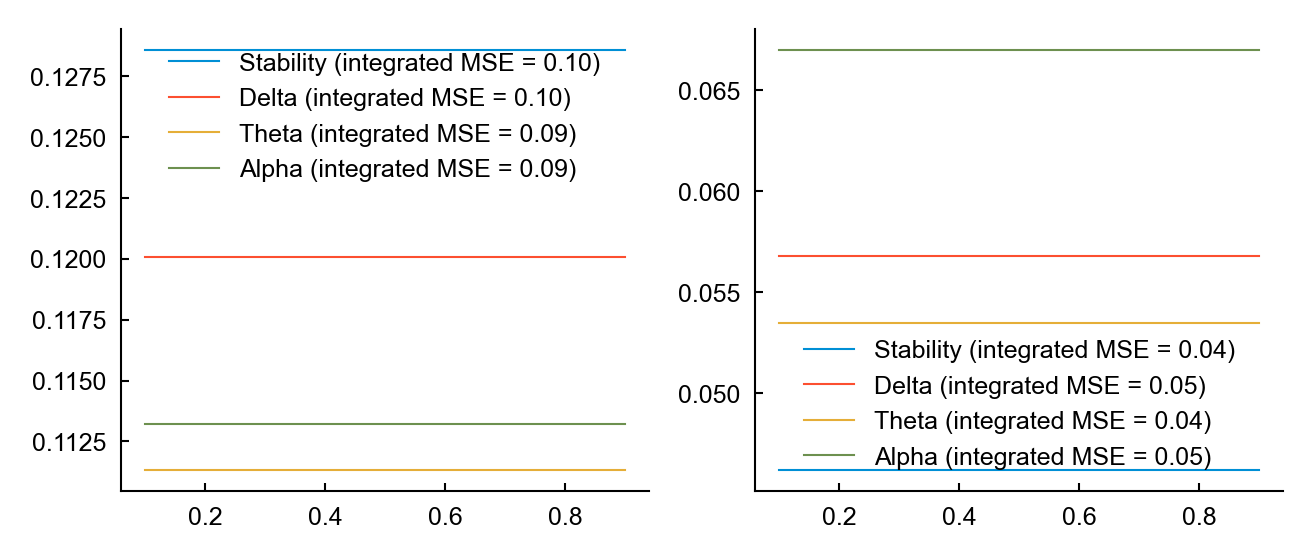

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2))

for i, monkey in enumerate(['SPOCK', 'PEDRI']):
    stab_pct_thresh_curve = np.array([np.mean(mse_data[monkey][pct_correct_thresh]['stab_mse_all']) for pct_correct_thresh in pct_correct_thresh_options])
    delta_pct_thresh_curve = np.array([np.mean(mse_data[monkey][pct_correct_thresh]['delta_mse_all']) for pct_correct_thresh in pct_correct_thresh_options])
    theta_pct_thresh_curve = np.array([np.mean(mse_data[monkey][pct_correct_thresh]['theta_mse_all']) for pct_correct_thresh in pct_correct_thresh_options])
    alpha_pct_thresh_curve = np.array([np.mean(mse_data[monkey][pct_correct_thresh]['alpha_mse_all']) for pct_correct_thresh in pct_correct_thresh_options])
    stab_int = np.trapezoid(stab_pct_thresh_curve, pct_correct_thresh_options)
    delta_int = np.trapezoid(delta_pct_thresh_curve, pct_correct_thresh_options)
    theta_int = np.trapezoid(theta_pct_thresh_curve, pct_correct_thresh_options)
    alpha_int = np.trapezoid(alpha_pct_thresh_curve, pct_correct_thresh_options)
    axs[i].plot(pct_correct_thresh_options, stab_pct_thresh_curve, label='Stability (integrated MSE = {:.2f})'.format(stab_int))
    axs[i].plot(pct_correct_thresh_options, delta_pct_thresh_curve, label='Delta (integrated MSE = {:.2f})'.format(delta_int))
    axs[i].plot(pct_correct_thresh_options, theta_pct_thresh_curve, label='Theta (integrated MSE = {:.2f})'.format(theta_int))
    axs[i].plot(pct_correct_thresh_options, alpha_pct_thresh_curve, label='Alpha (integrated MSE = {:.2f})'.format(alpha_int))
    axs[i].legend()
plt.show()

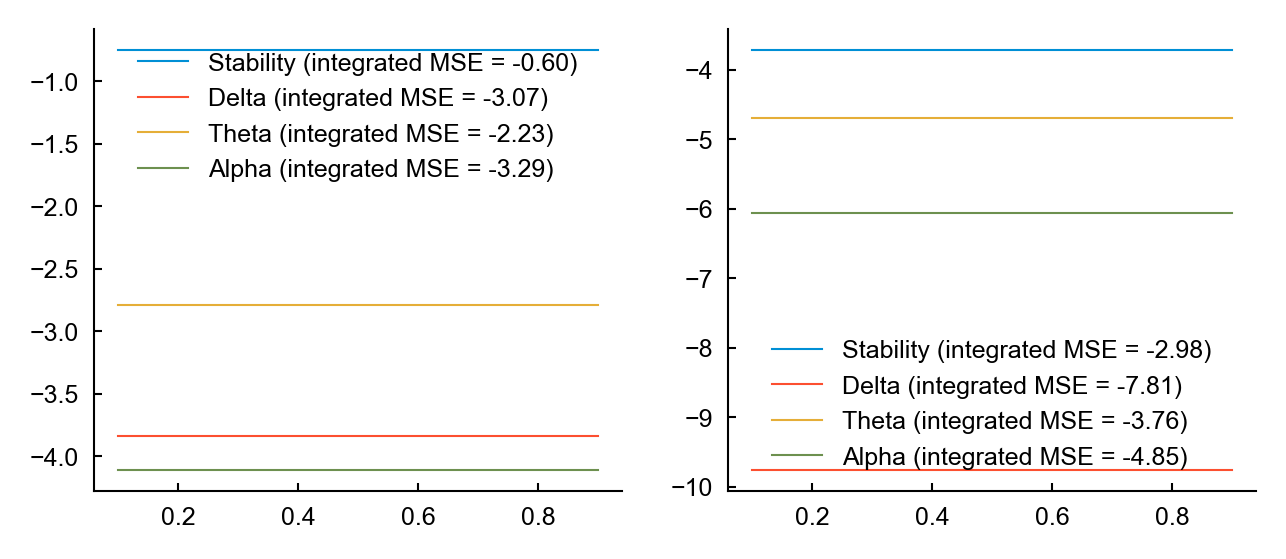

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2))

for i, monkey in enumerate(['SPOCK', 'PEDRI']):
    stab_pct_thresh_curve = np.array([np.mean(r2_data[monkey][pct_correct_thresh]['stab_r2_all']) for pct_correct_thresh in pct_correct_thresh_options])
    delta_pct_thresh_curve = np.array([np.mean(r2_data[monkey][pct_correct_thresh]['delta_r2_all']) for pct_correct_thresh in pct_correct_thresh_options])
    theta_pct_thresh_curve = np.array([np.mean(r2_data[monkey][pct_correct_thresh]['theta_r2_all']) for pct_correct_thresh in pct_correct_thresh_options])
    alpha_pct_thresh_curve = np.array([np.mean(r2_data[monkey][pct_correct_thresh]['alpha_r2_all']) for pct_correct_thresh in pct_correct_thresh_options])
    stab_int = np.trapezoid(stab_pct_thresh_curve, pct_correct_thresh_options)
    delta_int = np.trapezoid(delta_pct_thresh_curve, pct_correct_thresh_options)
    theta_int = np.trapezoid(theta_pct_thresh_curve, pct_correct_thresh_options)
    alpha_int = np.trapezoid(alpha_pct_thresh_curve, pct_correct_thresh_options)
    axs[i].plot(pct_correct_thresh_options, stab_pct_thresh_curve, label='Stability (integrated MSE = {:.2f})'.format(stab_int))
    axs[i].plot(pct_correct_thresh_options, delta_pct_thresh_curve, label='Delta (integrated MSE = {:.2f})'.format(delta_int))
    axs[i].plot(pct_correct_thresh_options, theta_pct_thresh_curve, label='Theta (integrated MSE = {:.2f})'.format(theta_int))
    axs[i].plot(pct_correct_thresh_options, alpha_pct_thresh_curve, label='Alpha (integrated MSE = {:.2f})'.format(alpha_int))
    axs[i].legend()
plt.show()

In [85]:
# integrate over pct_correct_thresh_options

print(np.trapezoid(stab_pct_thresh_curve, pct_correct_thresh_options))
print(np.trapezoid(delta_pct_thresh_curve, pct_correct_thresh_options))
print(np.trapezoid(theta_pct_thresh_curve, pct_correct_thresh_options))
print(np.trapezoid(alpha_pct_thresh_curve, pct_correct_thresh_options))


0.7770915019784737
0.7514582720941791
0.7700910782170511
0.7599318503869834


In [ ]:

print(delta_p_value, theta_p_value, alpha_p_value)

0.00390625 0.62890625 0.37109375


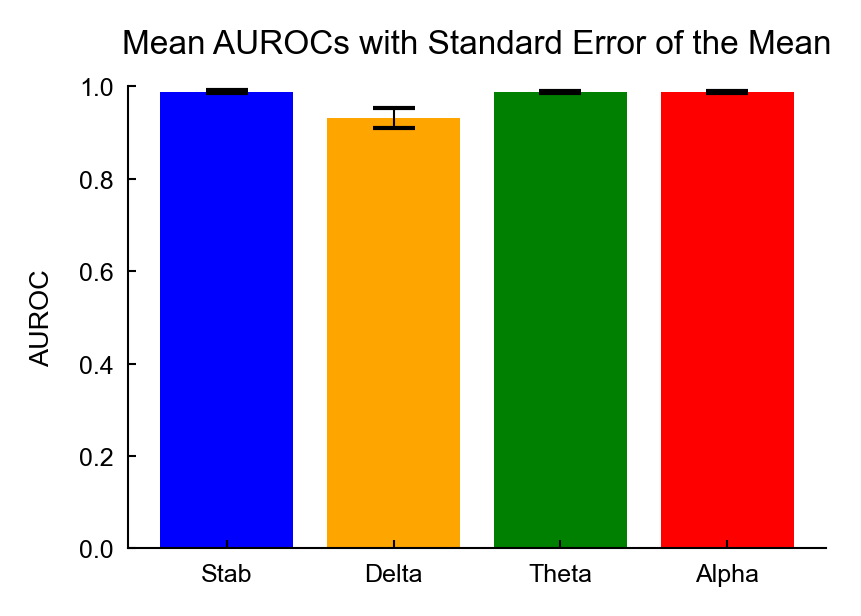

In [70]:
import matplotlib.pyplot as plt
from scipy.stats import sem

# Data for plotting
labels = ['Stab', 'Delta', 'Theta', 'Alpha']
aurocs_all = [stab_aurocs_all, delta_aurocs_all, theta_aurocs_all, alpha_aurocs_all]
mean_aurocs = [np.mean(aurocs) for aurocs in aurocs_all]
sem_aurocs = [sem(aurocs) for aurocs in aurocs_all]

# Create bar plot
fig, ax = plt.subplots()
ax.bar(labels, mean_aurocs, yerr=sem_aurocs, capsize=5, color=['blue', 'orange', 'green', 'red'])

# Add labels and title
ax.set_ylabel('AUROC')
ax.set_title('Mean AUROCs with Standard Error of the Mean')
ax.set_ylim(0, 1)

# Show plot
plt.show()


/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3768698/263278979.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem_mse = [sem(mse) for mse in mse_all]


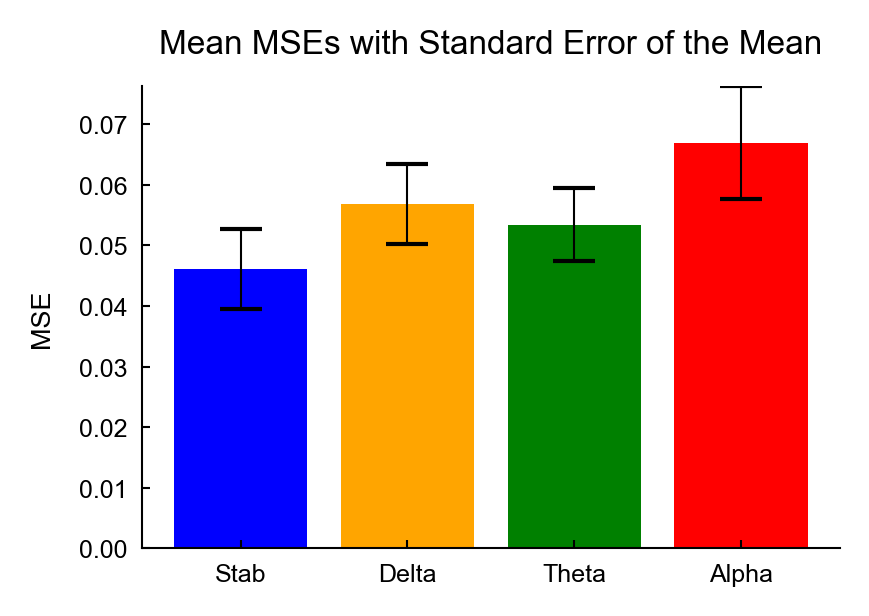

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import sem

# Data for plotting
labels = ['Stab', 'Delta', 'Theta', 'Alpha', 'Low Freq\nSpectrum']
mse_all = [stab_mse_all, delta_mse_all, theta_mse_all, alpha_mse_all, spectral_mse_all]
mean_mse = [np.mean(mse) for mse in mse_all]
sem_mse = [sem(mse) for mse in mse_all]

# Create bar plot
fig, ax = plt.subplots()
ax.bar(labels, mean_mse, yerr=sem_mse, capsize=5, color=['blue', 'orange', 'green', 'red', 'purple'])

# Add labels and title
ax.set_ylabel('MSE')
ax.set_title('Mean MSEs with Standard Error of the Mean')
ax.set_ylim(0, max(mean_mse) + max(sem_mse))

# Show plot
plt.show()


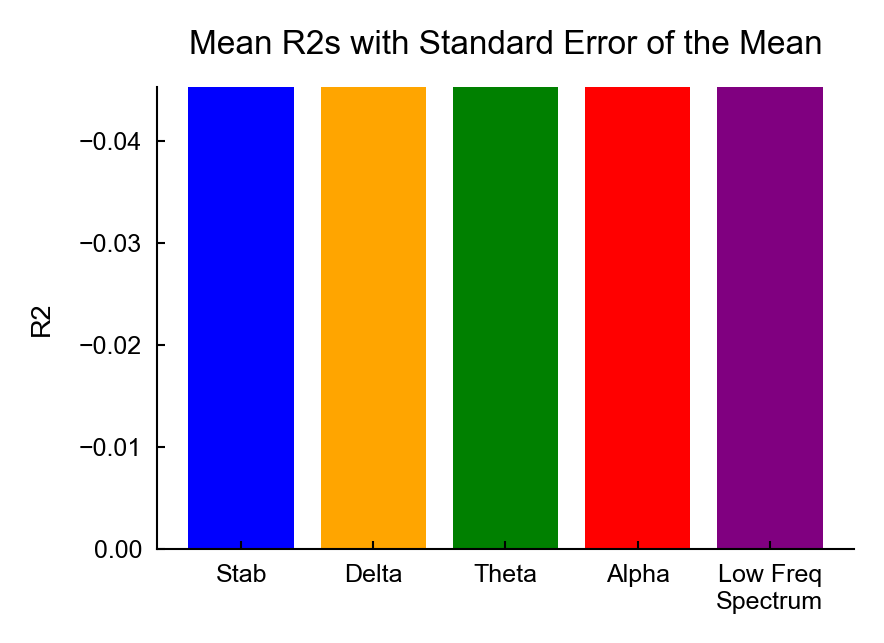

In [41]:
import matplotlib.pyplot as plt
from scipy.stats import sem

# Data for plotting
labels = ['Stab', 'Delta', 'Theta', 'Alpha', 'Low Freq\nSpectrum']
r2_all = [stab_r2_all, delta_r2_all, theta_r2_all, alpha_r2_all, spectral_r2_all]
mean_r2 = [np.mean(r2) for r2 in r2_all]
sem_r2 = [sem(r2) for r2 in r2_all]

# Create bar plot
fig, ax = plt.subplots()
ax.bar(labels, mean_r2, yerr=sem_r2, capsize=5, color=['blue', 'orange', 'green', 'red', 'purple'])

# Add labels and title
ax.set_ylabel('R2')
ax.set_title('Mean R2s with Standard Error of the Mean')
ax.set_ylim(0, max(mean_r2) + max(sem_r2))

# Show plot
plt.show()
